# Fetch Codebase and Models

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'starter_project'
!git clone https://github.com/yuzq97/starter_project.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 178 (delta 33), reused 159 (delta 20), pack-reused 0
Receiving objects: 100% (178/178), 2.89 MiB | 12.09 MiB/s, done.
Resolving deltas: 100% (33/33), done.


# Define Utility Functions

In [2]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type, seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [4]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "Z" #@param ['Z', 'W']

generator = build_generator(model_name)

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

C_ATTRS = ['age_c_eyeglasses','age_c_gender','eyeglasses_c_age','eyeglasses_c_gender']
conditional_boundaries = {}
for attr_name in C_ATTRS:
  boundary_name = f'{model_name}_{attr_name}'
  conditional_boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')
  

Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
Successfully loaded!


# Sample latent codes

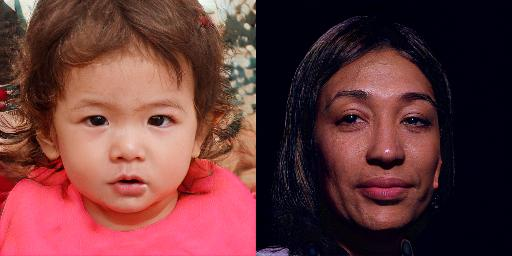

In [11]:
#@title { display-mode: "form", run: "auto" }

num_samples = 2 #@param {type:"slider", min:1, max:4, step:1}
num_steps = 8 #@param {type:"slider", min:3, max:10, step:1}
noise_seed = 350 #@param {type:"slider", min:0, max:1000, step:1}

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

# Edit unconditioned facial attributes

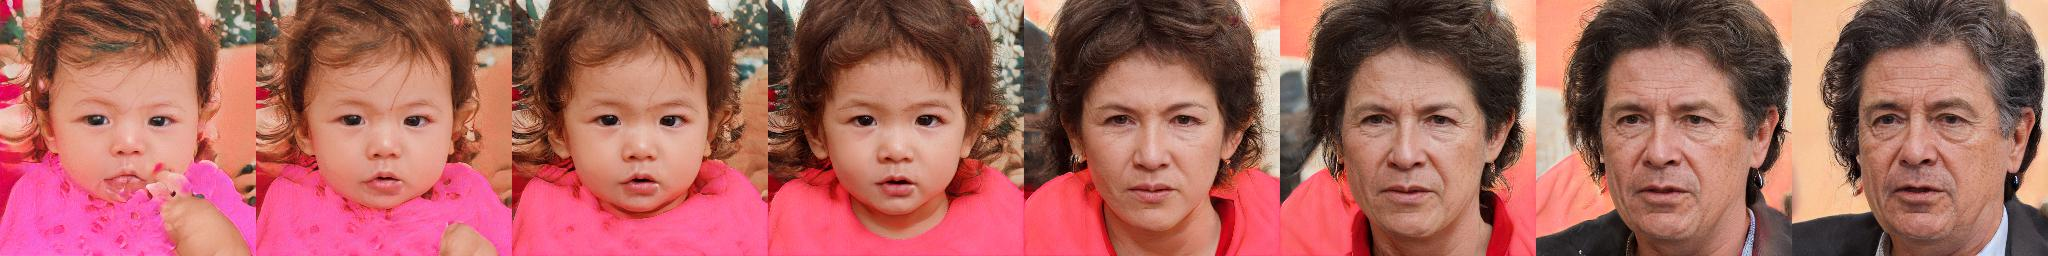

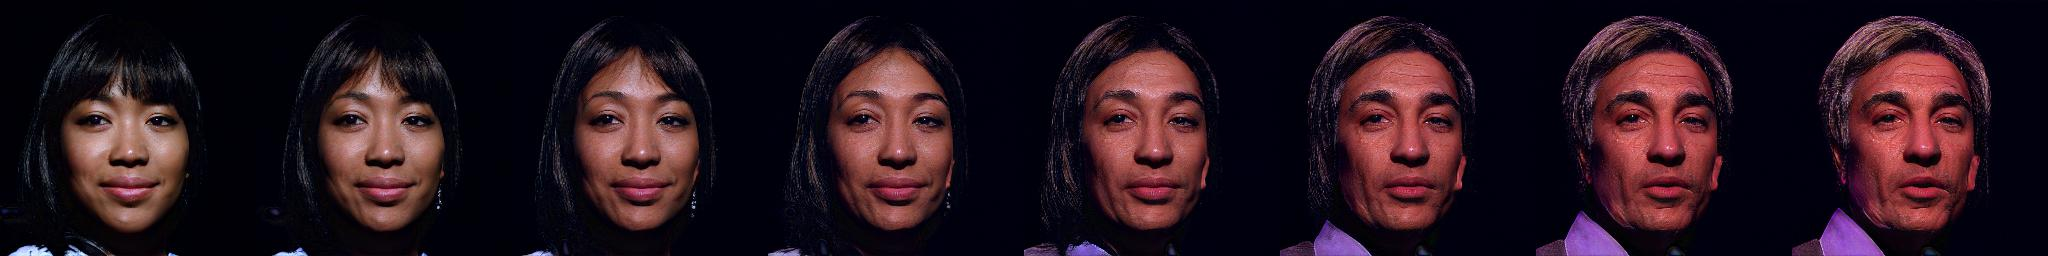

In [12]:
#@title { display-mode: "form", run: "auto" }
attribute = "age" #@param ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundary = boundaries[attribute]

total_num = latent_codes.shape[0]
for sample_id in range(total_num):
  interpolations = linear_interpolate(latent_codes[sample_id:sample_id + 1],
                                      boundary,
                                      start_distance=-3.0,
                                      end_distance=3.0,
                                      steps=num_steps)
  images = []
  for interpolations_batch in generator.get_batch_inputs(interpolations):
    outputs = generator.easy_synthesize(interpolations_batch, **synthesis_kwargs)
    image = outputs['image']
    images.append(image)
  
  images = np.concatenate(images)
  imshow(images,col=num_steps)

# Edit conditional facial attributes

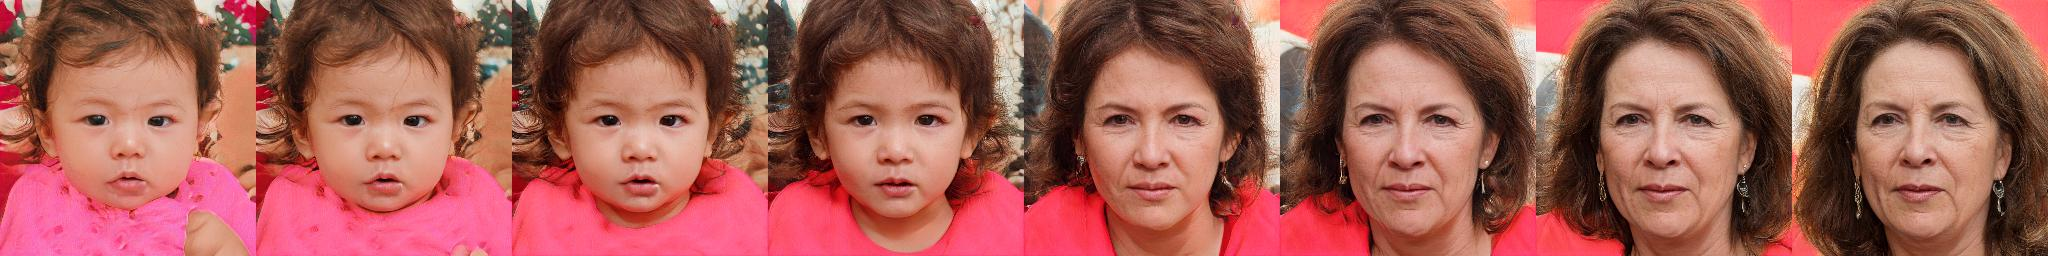

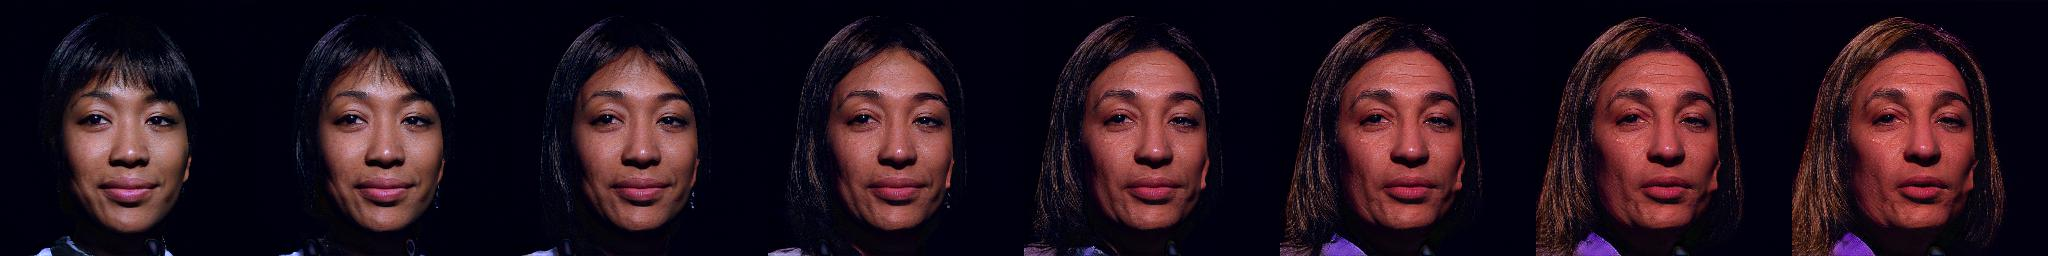

In [13]:
#@title { display-mode: "form", run: "auto" }
conditional_attribute = "age_c_gender" #@param ['age_c_eyeglasses','age_c_gender','eyeglasses_c_age','eyeglasses_c_gender']

if latent_space_type == "W":
  raise AttributeError('Conditional manipulation does not work in W space')
else:
  boundary = conditional_boundaries[conditional_attribute]
  total_num = latent_codes.shape[0]
  for sample_id in range(total_num):
    interpolations = linear_interpolate(latent_codes[sample_id:sample_id + 1],
                                        boundary,
                                        start_distance=-2.0,
                                        end_distance=3.0,
                                        steps=num_steps)
    images = []
    for interpolations_batch in generator.get_batch_inputs(interpolations):
      outputs = generator.easy_synthesize(interpolations_batch, **synthesis_kwargs)
      image = outputs['image']
      images.append(image)
    
    images = np.concatenate(images)
    imshow(images,col=num_steps)